# Quick Start

This notebook gives a quick introduction into DeepSphere for TF 2.x.

We use the same data as in the original [DeepSphere repo](https://github.com/SwissDataScienceCenter/DeepSphere).

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN, healpy_layers as hp_layer

## 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with.
It is made of 200 maps of size `nside=64` splitted in 2 classes. 

The maps contain Gaussian random field realisations produced by the `synfast` function from `healpy`.
The input power spectra were taken from a ΛCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `nside=64` to make processing faster.

In [2]:
data = np.load('../data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

Let us plot a map of each class. It is not simple to visually catch the differences.

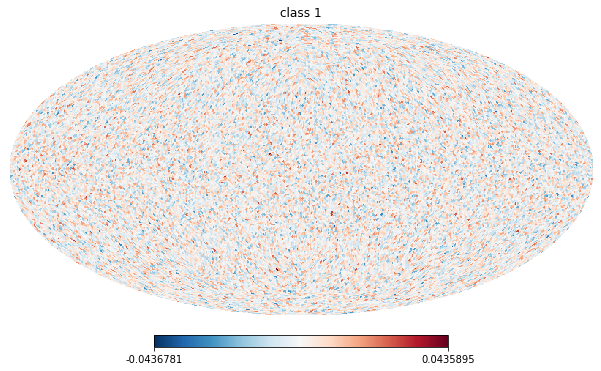

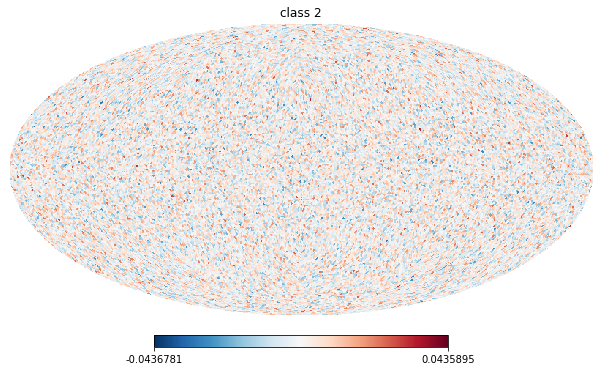

In [3]:
cmin = min(np.min(data['class1']), np.min(data['class2']))
cmax = max(np.max(data['class1']), np.max(data['class2']))
cm = plt.cm.RdBu_r
hp.mollview(data['class1'][0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)
hp.mollview(data['class2'][0], title='class 2', nest=True, cmap=cm, min=cmin, max=cmax)

## 2 Classification using DeepSphere

Here we will define a network and train it such that it can correctly classifiy the two classes of maps.
We start by defining the layers we want to use.
The `HealpyGCNN` class is a subclass of `tf.keras.Sequential`, meaning we can use a lot of the already existing TF functionality and can even interlace normal layers with our graph convolutions if we want to.

In [4]:
layers = [hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=2),
          tf.keras.layers.Lambda(lambda x: tf.nn.softmax(tf.reduce_mean(x, axis=1),
                                                         axis=-1))]

Now we define the `nside` and the relevant pixels (indices).

In [5]:
nside = 64
indices = np.arange(hp.nside2npix(nside))

We build the network with an input shape and print out a summary.

In [6]:
tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
batch_size = 16
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
chebyshev (Chebyshev)                            (None, 49152, 5)                            65               
______________________________________________________________________________________________________________
healpy_pool (HealpyPool)                         (None, 12288, 5)                            0                
______________________________________________________________________________________________________________
chebyshev_1 (Chebyshev)                          (None, 12288, 5)                            265              
________________________

We create a dataset for the training with a channel dimension (not strictly necessary if you use the TF routines for training) and labels.

In [7]:
x_raw = np.concatenate([data["class1"], data["class2"]]).astype(np.float32)[..., None]
y_raw = np.concatenate([np.zeros(nclass), np.ones(nclass)]).astype(np.float32)

np.random.RandomState(11).shuffle(x_raw)
np.random.RandomState(11).shuffle(y_raw)

x_train, x_test = np.split(x_raw, indices_or_sections=[150])
y_train, y_test = np.split(y_raw, indices_or_sections=[150])

We compile the model.

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [9]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(x_test, y_test),
)

Epoch 1/20
10/10 [==============================] - 5s 544ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.8200 - val_loss: 18.1561 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/20
10/10 [==============================] - 5s 502ms/step - loss: 0.0051 - sparse_categorical_accuracy: 1.0000 - val_loss: 10.0636 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/20
10/10 [==============================] - 5s 492ms/step - loss: 0.0174 - sparse_categorical_accuracy: 0.9867 - val_loss: 2.8554 - val_sparse_categorical_accuracy: 0.4600
Epoch 4/20
10/10 [==============================] - 5s 502ms/step - loss: 4.0849e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 13.6551 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/20
10/10 [==============================] - 5s 519ms/step - loss: 0.0055 - sparse_categorical_accuracy: 1.0000 - val_loss: 19.1798 - val_sparse_categorical_accuracy: 0.4600
Epoch 6/20
10/10 [==============================] - 6s 583ms/step - loss: 0.0155 - sparse_ca

A final evaluation on the test set.

In [10]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 193ms/step - loss: 2.3842e-08 - sparse_categorical_accuracy: 1.0000


[2.384185648907078e-08, 1.0]

Let's plot the loss.
(Note that the history object contains much more info.)

Text(0, 0.5, 'Loss')

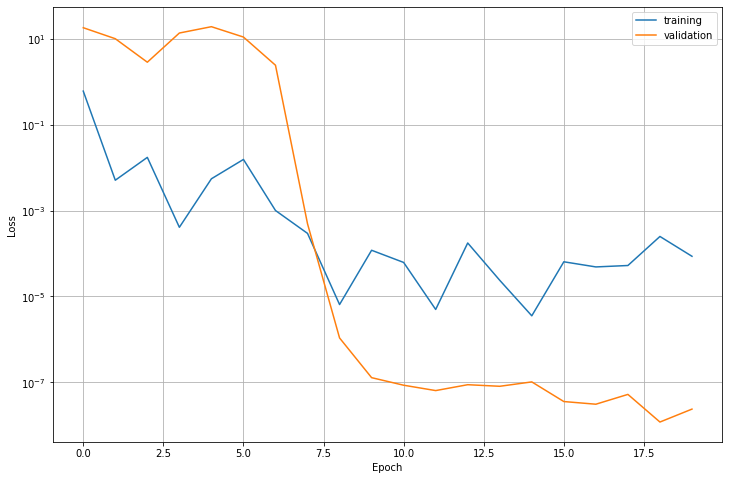

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

## 3 Filter Visualization

We observe the coefficiencts of the Chebyshev polynomials.
It is mostly interpretable by people for the graph signal processing community.

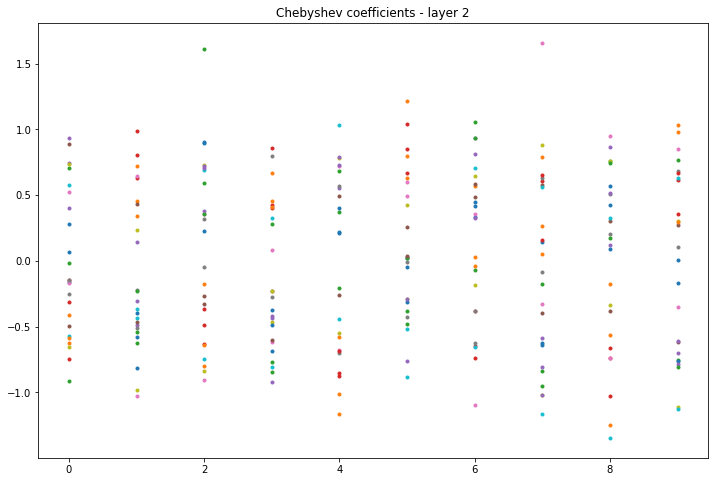

In [12]:
layer = 2
plt.figure(figsize=(12,8))
model.plot_chebyshev_coeffs(layer)

We observe the filters in the graph spectral domain.
This visuallization can help to understand which graph frequencies are picked by the filtering operation.

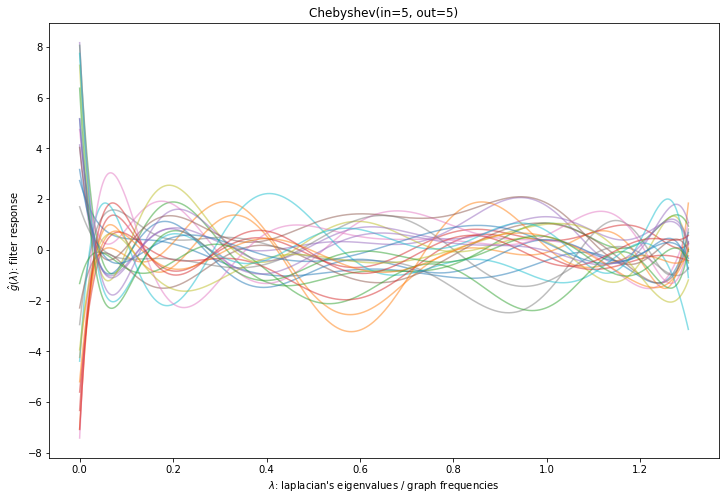

In [13]:
plt.figure(figsize=(12,8))
model.plot_filters_spectral(layer)

Here comes one of the most human friendly representation of the filters.
It consists of the section of the filters "projected" on the sphere.
Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

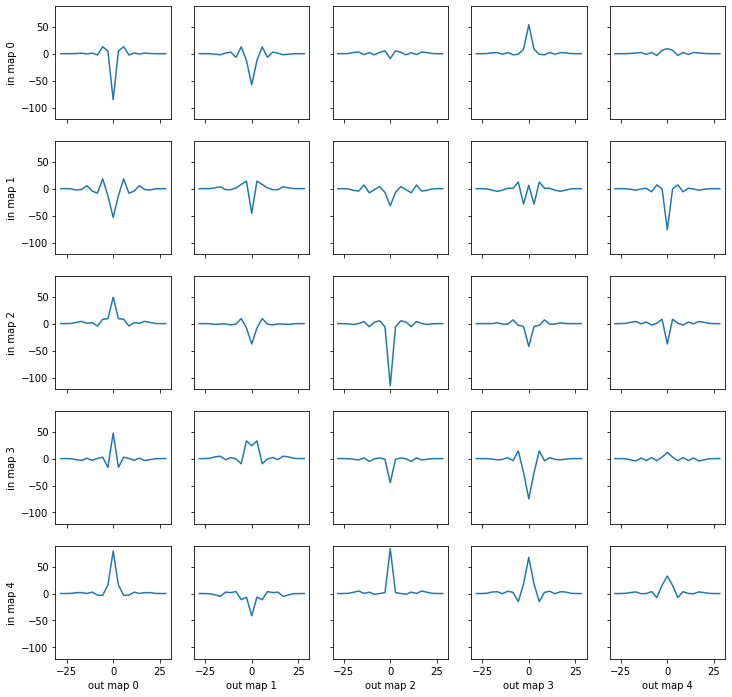

In [14]:
model.plot_filters_section(layer, title='');

Eventually, we can simply look at the filters on the sphere.
This representation clearly displays the sampling artifacts.

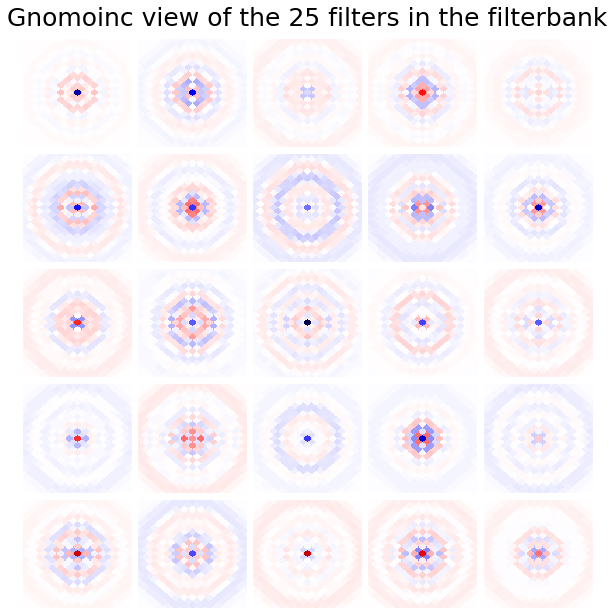

In [15]:
figs = model.plot_filters_gnomonic(layer, title=None)